ライブラリのインストール

In [1]:
import os
os.getcwd()

'C:\\Users\\ookalab\\Desktop\\dl_lecture_competition_pub'

In [11]:
import sys
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import Accuracy
import hydra
from omegaconf import DictConfig
import wandb
from termcolor import cprint
from tqdm import tqdm
from einops.layers.torch import Rearrange
from PIL import Image
import matplotlib.pyplot as plt

from src.datasets import ThingsMEGDataset
from src.models import BasicConvClassifier
from src.utils import set_seed

In [13]:
# シード値の設定
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [15]:
# Suppress DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cuda


画像データの取得・前処理

In [20]:
# 画像データの前処理
# Global Contrast Normalization(GCN)
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


# 標準化後の画像を[0, 1]に正規化する
def deprocess(x):
    """
    Argument
    --------
    x : np.ndarray
        入力画像．(H, W, C)

    Return
    ------
    _x : np.ndarray
        [0, 1]で正規化した画像．(H, W, C)
    """
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

GCN = gcn()
transform_GCN = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    GCN, 
    transforms.Lambda(lambda x: deprocess(x.numpy()).astype(np.float32))
])

In [22]:
# 画像データ: (バッチサイズ、チャンネル数、高さ、幅)
class CustomDataset(Dataset):
    def __init__(self, image_paths_file, image_folder, transform=None):
        self.image_paths = []
        self.indices = []
        self.none_relative_image_paths = []
        with open(image_paths_file, 'r') as f:
            for idx, line in enumerate(f):
                image_path = os.path.join(image_folder, line.strip())
                if os.path.exists(image_path):
                    self.image_paths.append(image_path)
                    self.indices.append(idx)
                else:
                    relative_path = os.path.relpath(image_path, image_folder)
                    self.none_relative_image_paths.append(relative_path)

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

    def get_relative_image_paths(self):
        relative_paths = [os.path.relpath(path, images) for path in self.image_paths]
        return relative_paths

    def get_none_relative_image_paths(self):
        return self.none_relative_image_paths


images = '.\\images'
train_image_paths = '.\\data\\train_image_paths.txt'
val_image_paths = '.\\data\\val_image_paths.txt'

train_dataset = CustomDataset(train_image_paths, images, transform=transform_GCN)
val_dataset = CustomDataset(val_image_paths, images, transform=transform_GCN)

images_train = DataLoader(train_dataset, batch_size=32, shuffle=False)
images_val = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
for batch in images_train:
    print (batch.shape)
    break

torch.Size([32, 3, 224, 224])


In [24]:
# images_trainの総数
print (len(train_dataset.get_relative_image_paths()))

# 不存在の画像パスの総数
print (len(train_dataset.get_none_relative_image_paths()))

# images_trainの総数+不存在の画像パスの総数が65728になっていればいい
print (len(train_dataset.get_relative_image_paths()) + len(train_dataset.get_none_relative_image_paths()))

59328
6400
65728


In [25]:
# images_valの総数
print (len(val_dataset.get_relative_image_paths()))

# 不存在の画像パスの総数
print (len(val_dataset.get_none_relative_image_paths()))

# images_valの総数+不存在の画像パスの総数が16432になっていればいい
print (len(val_dataset.get_relative_image_paths()) + len(val_dataset.get_none_relative_image_paths()))

14832
1600
16432


脳波データの取得・前処理

In [38]:
# 脳波データの取得
# x: (データ数, チャンネル数, 系列長)
# y: 正解ラベル

x_train_before_preprocessing = torch.load('.\\data\\train_X.pt')
y_train = torch.load('.\\data\\train_y.pt')

x_val_before_preprocessing = torch.load('.\\data\\val_X.pt')
y_val = torch.load('.\\data\\val_y.pt')

x_test_before_preprocessing = torch.load('.\\data\\test_X.pt')

In [39]:
# 脳波データの前処理
from scipy import signal
from sklearn.preprocessing import StandardScaler

# リサンプリング
def resample_data(data, original_fs, new_fs):
    data_np = data.numpy()
    num_samples = data_np.shape[2]
    new_num_samples = int(num_samples * new_fs / original_fs)
    resampled_data_np = signal.resample(data_np, new_num_samples, axis=2)
    resampled_data = torch.from_numpy(resampled_data_np)
    return resampled_data

# フィルタリング
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    data_np = data.numpy()
    filtered_data_np = signal.lfilter(b, a, data_np, axis=2)
    filtered_data = torch.from_numpy(filtered_data_np)
    return filtered_data

# スケーリング
def scale_data(data):
    original_shape = data.shape
    data_reshaped = data.view(-1, data.shape[2]).numpy()
    scaler = StandardScaler()
    scaled_data_np = scaler.fit_transform(data_reshaped)
    scaled_data = torch.from_numpy(scaled_data_np).view(original_shape)
    return scaled_data

# ベースライン補正
def baseline_correction(data):
    baseline_window=slice(0, int(len(data))//10)
    baseline = data[:, :, baseline_window].mean(dim=2, keepdim=True)
    corrected_data = data - baseline
    return corrected_data

# parameters
original_fs = 200
new_fs = 100
lowcut = 0.1
highcut = 40.0
fs = 100

# 前処理
def preprocessing(data):
    resampled_data = resample_data(data, original_fs, new_fs)
    filtered_data = bandpass_filter(resampled_data, lowcut, highcut, fs)
    scaled_data = scale_data(filtered_data)
    corrected_data = baseline_correction(scaled_data)
    return corrected_data

In [40]:
x_train = preprocessing(x_train_before_preprocessing)
x_val = preprocessing(x_val_before_preprocessing)
x_test = preprocessing(x_test_before_preprocessing)

In [41]:
print (x_train.shape)
print (x_val.shape)
print (x_test.shape)

torch.Size([65728, 271, 140])
torch.Size([16432, 271, 140])
torch.Size([16432, 271, 140])


In [42]:
x_train_for_pretrain = x_train[train_dataset.indices]
x_val_for_pretrain = x_val[val_dataset.indices]

In [43]:
print (len(x_train_for_pretrain))
print (len(x_val_for_pretrain))

59328
14832


事前学習

In [30]:
# 画像エンコーダ(CLIP Vision Model)
from transformers import CLIPProcessor, CLIPVisionModel

clip_model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPVisionModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, do_rescale=False)

clip_model.to(device)

def extract_clip_features(dataset, clip_model, clip_processor, device, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    clip_model.eval()
    
    num_batches = len(dataset)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataset, desc="Extracting features", total=num_batches)):
            batch = batch.to(device)
            inputs = clip_processor(images=batch, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = clip_model(**inputs)
            batch_features = outputs.pooler_output.cpu().numpy()
            
            batch_path = os.path.join(output_dir, f"features_batch_{batch_idx}.npy")
            np.save(batch_path, batch_features)
    
    all_features = []
    for batch_idx in range(num_batches):
        batch_path = os.path.join(output_dir, f"features_batch_{batch_idx}.npy")
        batch_features = np.load(batch_path)
        all_features.append(batch_features)
    
    all_features = np.concatenate(all_features, axis=0)
    return all_features

C:\Users\ookalab\anaconda2\envs\DLbasics\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
# 訓練データから特徴量を抽出
train_features = extract_clip_features(images_train, clip_model, clip_processor, device, output_dir="clip_features_train")

Extracting features: 100%|█████████████████████████████████████████████████████████| 1854/1854 [55:45<00:00,  1.80s/it]


In [34]:
# 検証データから特徴量を抽出
val_features = extract_clip_features(images_val, clip_model, clip_processor, device, output_dir="clip_features_val")

Extracting features: 100%|███████████████████████████████████████████████████████████| 464/464 [13:50<00:00,  1.79s/it]


In [35]:
print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

Train features shape: (59328, 1024)
Validation features shape: (14832, 1024)


In [413]:
# 脳波エンコーダ
# データセットクラスの定義
class EEGDataset(Dataset):
    def __init__(self, eeg_data, image_features):
        self.eeg_data = eeg_data
        self.image_features = torch.tensor(image_features, dtype=torch.float32)

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        eeg_sample = self.eeg_data[idx]
        image_feature = self.image_features[idx]
        return eeg_sample, image_feature

In [415]:
# Dataloaderの作成
batch_size = 16

train_dataset_for_pretrain = EEGDataset(x_train_for_pretrain, train_features)
train_dataloader_for_pretrain = DataLoader(train_dataset_for_pretrain, batch_size=batch_size, shuffle=True)

val_dataset_for_pretrain = EEGDataset(x_val_for_pretrain, val_features)
val_dataloader_for_pretrain = DataLoader(val_dataset_for_pretrain, batch_size=batch_size, shuffle=True)

In [416]:
for data, feature in train_dataloader_for_pretrain:
    print (data.shape)
    print (feature.shape)
    break

torch.Size([16, 271, 140])
torch.Size([16, 1024])


In [419]:
# 脳波エンコーダの作成
class EEG_Encoder(nn.Module):
    def __init__(self, input_channels, seq_length, embed_dim, num_heads, num_encoder_layers, dropout):
        super(EEG_Encoder, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, embed_dim, kernel_size=3, padding=1)
        self.pos_embedding = nn.Parameter(torch.randn(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=0,
            dropout=dropout
        )

    def forward(self, x):
        batch_size, _, _ = x.size()
        x = x.to(torch.float32)
        x = self.conv1(x)
        x = x.permute(2, 0, 1)
        x = x + self.pos_embedding.unsqueeze(1)
        x = self.transformer(x, x)
        x = x.mean(dim=0)
        return x

In [421]:
# ヘルパー関数の実装
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [423]:
# hyperparameters
input_channels = x_train_for_pretrain.size(1)
seq_length = x_train_for_pretrain.size(2)
embed_dim = 1024
num_heads = 8
num_encoder_layers = 3
dropout = 0.3
epochs = 1000
lr = 0.001
warmup_length = epochs * 0.05
step_count = 0

# モデルと損失関数の定義
model = EEG_Encoder(input_channels, seq_length, embed_dim, num_heads, num_encoder_layers, dropout).to(device)
criterion = nn.CosineEmbeddingLoss()

optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.1)
scheduler = CosineScheduler(epochs, lr, warmup_length)

In [425]:
# print (model)

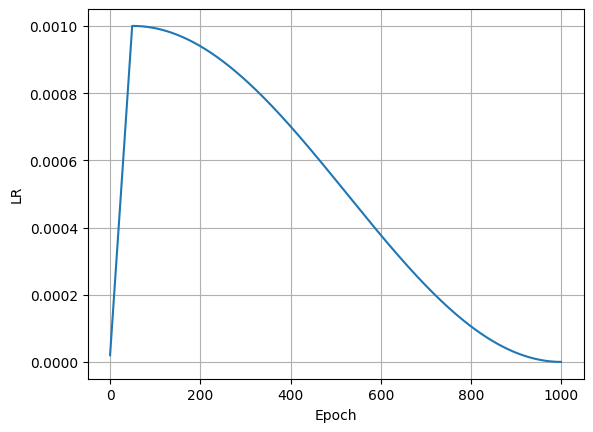

In [427]:
scheduler = CosineScheduler(epochs, lr, warmup_length)
x = np.arange(epochs)
plt.plot(x, [scheduler(epoch) for epoch in x])
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.show()

In [429]:
import time

def format_time(seconds):
    hours, rem = divmod(seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

In [431]:
total_time = 0
min_valid_loss = 1
early_stopping_patience = 75

# 事前学習
for epoch in range(epochs):
    epoch_start_time = time.time()

    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_valid_loss = 0.

    # モデルの訓練
    for eeg_data, image_feature in train_dataloader_for_pretrain:
        step_count += 1
        model.train()
        eeg_data, image_feature = eeg_data.to(device), image_feature.to(device)

        eeg_feature = model(eeg_data)
        train_loss = criterion(eeg_feature, image_feature, torch.ones(eeg_feature.size(0)).to(device))
        train_loss.backward()

        if step_count % 8 == 0:  # 8イテレーションごとに更新することで、擬似的にバッチサイズを大きくしている
            optimizer.step()
            optimizer.zero_grad()

        total_train_loss += train_loss.item()

    # モデルの評価
    with torch.no_grad():
        for eeg_data, image_feature in val_dataloader_for_pretrain:
            model.eval()
            eeg_data, image_feature = eeg_data.to(device), image_feature.to(device)

            eeg_feature = model(eeg_data)
            valid_loss = criterion(eeg_feature, image_feature, torch.ones(eeg_feature.size(0)).to(device))

            total_valid_loss += valid_loss.item()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    total_time += epoch_duration

    if epoch % 10 == 9 or epoch == 0:
        formatted_epoch_duration = format_time(epoch_duration)
        formatted_total_time = format_time(total_time)

        print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(train_dataloader_for_pretrain):.4f} Valid Loss: {total_valid_loss/len(val_dataloader_for_pretrain):.4f} Duration: {formatted_epoch_duration} Total Time: {formatted_total_time}")

    # モデルの保存
    torch.save(model.state_dict(), 'eeg_pretrain_params_last.pth')

    # 一番性能の良いモデルの保存、早期終了チェック
    if total_valid_loss/len(val_dataloader_for_pretrain) < min_valid_loss:
        torch.save(model.state_dict(), 'eeg_pretrain_params_best.pth')
        min_valid_loss = total_valid_loss/len(val_dataloader_for_pretrain)
        patience_counter = 0

    else:
        patience_counter += 1

    if patience_counter > early_stopping_patience:
        print("Early stopping triggered")
        break

Epoch[1 / 1000] Train Loss: 0.8653 Valid Loss: 0.7503 Duration: 00:01:32 Total Time: 00:01:32
Epoch[10 / 1000] Train Loss: 0.4355 Valid Loss: 0.4387 Duration: 00:01:29 Total Time: 00:15:07
Epoch[20 / 1000] Train Loss: 0.4338 Valid Loss: 0.4384 Duration: 00:01:29 Total Time: 00:30:06
Epoch[30 / 1000] Train Loss: 0.4333 Valid Loss: 0.4381 Duration: 00:01:30 Total Time: 00:45:06
Epoch[40 / 1000] Train Loss: 0.4332 Valid Loss: 0.4379 Duration: 00:01:31 Total Time: 01:00:17
Epoch[50 / 1000] Train Loss: 0.4331 Valid Loss: 0.4376 Duration: 00:01:30 Total Time: 01:15:22
Epoch[60 / 1000] Train Loss: 0.4327 Valid Loss: 0.4375 Duration: 00:01:30 Total Time: 01:30:26
Epoch[70 / 1000] Train Loss: 0.4325 Valid Loss: 0.4372 Duration: 00:01:30 Total Time: 01:45:30
Epoch[80 / 1000] Train Loss: 0.4323 Valid Loss: 0.4372 Duration: 00:01:30 Total Time: 02:00:33
Epoch[90 / 1000] Train Loss: 0.4322 Valid Loss: 0.4373 Duration: 00:01:29 Total Time: 02:15:30
Epoch[100 / 1000] Train Loss: 0.4321 Valid Loss: 0.

クラス分類

In [433]:
del model, train_loss, valid_loss
torch.cuda.empty_cache()

In [435]:
# 脳波エンコーダの読み込み
pretrained_model = EEG_Encoder(input_channels, seq_length, embed_dim, num_heads, num_encoder_layers, dropout).to(device)
pretrained_model.load_state_dict(torch.load('eeg_pretrain_params_best.pth', map_location=device))

<All keys matched successfully>

In [437]:
# クラス分類器(MLP)
class Classifier(nn.Module):
    def __init__(self, encoder_model, hidden_dim, output_dim, dropout_prob):
        super(Classifier, self).__init__()
        self.encoder = encoder_model
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        encoded_features = self.encoder(x)
        return self.mlp(encoded_features)

In [439]:
# hyperparameters
hidden_dim = 2048
output_dim = 1854
dropout_prob = 0.4
epochs = 100
lr = 0.0001
warmup_length = epochs * 0.05
step_count = 0

classifier = Classifier(pretrained_model, hidden_dim, output_dim, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(classifier.mlp.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.1)
scheduler = CosineScheduler(epochs, lr, warmup_length)

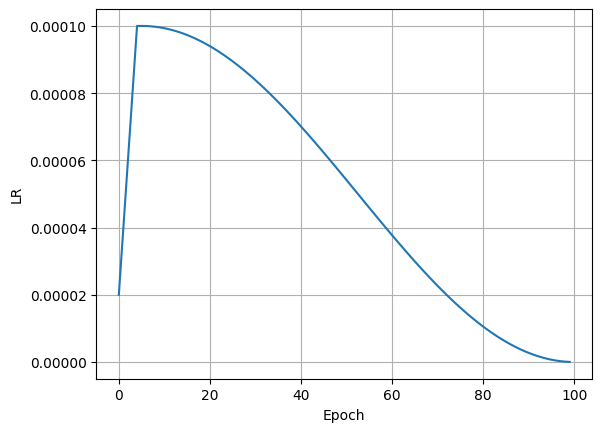

In [441]:
scheduler = CosineScheduler(epochs, lr, warmup_length)
x = np.arange(epochs)
plt.plot(x, [scheduler(epoch) for epoch in x])
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.show()

In [443]:
class train_dataset(Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.y_train[idx], dtype=torch.long)

class val_dataset(Dataset):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val

    def __len__(self):
        return self.x_val.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_val[idx], dtype=torch.float), torch.tensor(self.y_val[idx], dtype=torch.long)

class test_dataset(Dataset):
    def __init__(self, x_test):
        self.x_test = x_test

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)

train_data = train_dataset(x_train, y_train)
val_data = val_dataset(x_val, y_val)
test_data = test_dataset(x_test)

In [445]:
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [447]:
# 学習
accuracy = Accuracy(task="multiclass", num_classes=1854, top_k=10).to(device)
total_time_1 = 0
max_val_acc = 0.
early_stopping_patience_1 = 10

for epoch in range(epochs):
    epoch_start_time = time.time()

    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_train_acc = 0.
    total_valid_loss = 0.
    total_valid_acc = 0.
   
    # モデルの訓練
    classifier.train()
    for x, t in dataloader_train:
        step_count += 1
        x, t = x.to(device), t.to(device)

        pred = classifier(x)
        train_loss = criterion(pred, t)
        train_acc = accuracy(pred, t)
        train_loss.backward()

        if step_count % 4 == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_train_loss += train_loss.item()
        total_train_acc += train_acc.item()

    # モデルの評価
    classifier.eval()
    with torch.no_grad():
        for x, t in dataloader_val:
            x, t = x.to(device), t.to(device)

            pred = classifier(x)
            valid_loss = criterion(pred, t)
            valid_acc = accuracy(pred, t)

            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc.item()
    
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    total_time_1 += epoch_duration

    if epoch % 2 == 1 or epoch == 0:
        formatted_epoch_duration = format_time(epoch_duration)
        formatted_total_time = format_time(total_time_1)

        print(f"Epoch[{epoch+1} / {epochs}]",
              f"Train Loss: {total_train_loss/len(dataloader_train):.4f}",
              f"Train Acc.: {total_train_acc/len(dataloader_train):.4f}",
              f"Valid Loss: {total_valid_loss/len(dataloader_val):.4f}",
              f"Valid Acc.: {total_valid_acc/len(dataloader_val):.4f}",
              f"Duration: {formatted_epoch_duration}",
              f"Total Time: {formatted_total_time}")

    # モデルを保存
    torch.save(classifier.state_dict(), 'eeg_classifier_params_last.pth')

    # 一番性能の良いモデルの保存、早期終了チェック
    if total_valid_acc/len(dataloader_val) > max_val_acc:
        torch.save(classifier.state_dict(), 'eeg_classifier_params_best.pth')
        max_val_acc = total_valid_acc/len(dataloader_val)
        patience_counter = 0

    else:
        patience_counter += 1

    if patience_counter > early_stopping_patience_1:
        print("Early stopping triggered")
        break

Epoch[1 / 100] Train Loss: 7.5215 Train Acc.: 0.0078 Valid Loss: 7.5041 Valid Acc.: 0.0096 Duration: 00:03:33 Total Time: 00:03:33
Epoch[2 / 100] Train Loss: 7.5089 Train Acc.: 0.0076 Valid Loss: 7.4946 Valid Acc.: 0.0105 Duration: 00:01:48 Total Time: 00:05:22
Epoch[4 / 100] Train Loss: 7.4631 Train Acc.: 0.0136 Valid Loss: 7.4416 Valid Acc.: 0.0156 Duration: 00:01:46 Total Time: 00:08:57
Epoch[6 / 100] Train Loss: 7.4200 Train Acc.: 0.0156 Valid Loss: 7.4267 Valid Acc.: 0.0173 Duration: 00:01:47 Total Time: 00:12:32
Epoch[8 / 100] Train Loss: 7.3816 Train Acc.: 0.0207 Valid Loss: 7.4023 Valid Acc.: 0.0200 Duration: 00:01:48 Total Time: 00:16:08
Epoch[10 / 100] Train Loss: 7.3495 Train Acc.: 0.0236 Valid Loss: 7.3895 Valid Acc.: 0.0215 Duration: 00:01:47 Total Time: 00:19:44
Epoch[12 / 100] Train Loss: 7.3194 Train Acc.: 0.0246 Valid Loss: 7.3852 Valid Acc.: 0.0225 Duration: 00:01:47 Total Time: 00:23:21
Epoch[14 / 100] Train Loss: 7.2935 Train Acc.: 0.0274 Valid Loss: 7.3862 Valid Ac

In [457]:
# クラス分類器の読み込み
trained_classifier = Classifier(pretrained_model, hidden_dim, output_dim, dropout_prob).to(device)
trained_classifier.load_state_dict(torch.load('eeg_classifier_params_best.pth', map_location=device))

<All keys matched successfully>

In [458]:
trained_classifier.eval()
preds = []

for x in dataloader_test:
    x = x.to(device)
    y = trained_classifier(x)

    preds.append(y.detach().cpu())

preds = torch.cat(preds, dim=0).numpy()
np.save('submission_pred.npy', preds)